# Импортируем библиотеки

In [2]:
from lightgbm import LGBMRegressor
import pandas as pd
import lightgbm as lgb
from sklearn.inspection import permutation_importance
import random
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
import os
import contextlib
import warnings
from sklearn.metrics import mean_absolute_percentage_error as mape
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.inspection import permutation_importance
from sklearn.model_selection import  GridSearchCV
from tqdm import tqdm
import statsmodels.api as sm

# Загрузка данных

Будем использовать mte кодировку, так как будем работать с lightgbm

In [3]:
df_le=pd.read_csv(r"C:\Users\Stepan\Desktop\ВУЗ\Клиент-серверные\папка датафреймов\df_after_feat_eng_le.csv")
df_mte=pd.read_csv(r"C:\Users\Stepan\Desktop\ВУЗ\Клиент-серверные\папка датафреймов\df_after_feat_eng_mte.csv")
df_le=df_le.drop('Unnamed: 0', axis=1)
df_mte=df_mte.drop('Unnamed: 0', axis=1)
df_le.sample(5)

,metro_name,time_to_metro,num_rooms,total_area,year_house,kitchen_area,repair,price,floors,num_floor,...,district,metro_line,metro_distance,distr*time,Kre*time,Kre*area,year*area,year*repair,year*floors,area/num+1
19162,Перово,5.0,1,22.0,1987.0,8.0,2,9300000.0,12.0,3.0,...,94,4,4.84,470.0,49.20,216.48,43714.0,3974.0,23844.0,11.000000
22329,NaN,-1.0,3,42.5,1700.0,6.5,3,12850000.0,17.0,12.0,...,0,1,26.58,-0.0,-32.58,1384.65,72250.0,5100.0,28900.0,10.625000
10308,Окская,5.0,2,23.5,1700.0,3.0,2,10350000.0,12.0,9.0,...,104,9,7.12,520.0,55.60,261.32,39950.0,3400.0,20400.0,7.833333
13810,Аминьевская,5.0,2,26.0,1700.0,12.5,2,15259178.0,33.0,21.0,...,92,1,5.68,460.0,58.40,303.68,44200.0,3400.0,56100.0,8.666667
6743,Минская,13.0,4,190.0,1700.0,23.0,3,126000000.0,36.0,26.0,...,102,12,6.18,1326.0,106.34,1554.20,323000.0,5100.0,61200.0,38.000000


In [4]:
df_le.shape

(27974, 26)

# Важности признаков

Будем двигаться от более легких методов к более сложным.

## Split 

Посмотрим простейший способ получения важности под названием split, который встроен в lightgbm. Важность признака определяется по количеству использований признака для сплита в течение всего процесса обучения.

Для этого сначала обучим градиентный бустинг на кросс-валидации. Также перед этим потюним модель.

In [5]:
X,y=df_le.drop(['coord_width', 'coord_len', 'link', 'address', 'metro_name', 'price', 'date'], axis=1), df_mte['price']
X_tr, X_v,y_tr, y_v=train_test_split(X,y, test_size=0.8)

In [5]:
lgbm=LGBMRegressor(bagging_fraction=0.5, random_state=42)
param_grid={'learning_rate':[0.01,0.05,0.1,0.2], 'n_estimators':[1000,2000, 4000], 'lambda_l1':[5,15,30]}
gd=GridSearchCV(lgbm, param_grid, cv=5)
with open(os.devnull, "w") as f, contextlib.redirect_stdout(f):
    gd.fit(X,y)
print(f'best params: {gd.best_params_}')

best params: {'lambda_l1': 15, 'learning_rate': 0.05, 'n_estimators': 4000}


Считаем важности признаков на кросс-валидации.

In [6]:
skf = StratifiedKFold(n_splits=4, random_state=42, shuffle=True)
importance=[]
with open(os.devnull, "w") as f, contextlib.redirect_stdout(f):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        for tr_ind, val_ind in skf.split(X, y):
            lgbm=LGBMRegressor(bagging_fraction=0.5, random_state=42, **gd.best_params_)
            lgbm.fit(X.loc[tr_ind,:], y.loc[tr_ind])
            importance.append(lgbm.booster_.feature_importance())


In [7]:
feat_imp=np.mean(np.array(importance), axis=0)
feat_imp

array([ 1792.  ,  1517.75, 11655.75,  4039.25,  8814.25,  1366.  ,
        4657.5 ,  9947.25,  8136.25,  4997.25,  3410.  ,  8363.75,
        5719.  ,  7006.25,  9112.75,  7400.5 ,  4136.5 ,  6455.  ,
       11473.  ])

Отсортированный словарь "признак": количество сплитов.

In [8]:
dict_imp={X.columns[i]:feat_imp[i] for i in range(X.shape[1])}
dict_imp_s=sorted(dict_imp, key=lambda x: dict_imp[x], reverse=True)
f_dict={}
for i in dict_imp_s:
    f_dict[i]=dict_imp[i]
f_dict

{'total_area': 11655.75,
 'area/num+1': 11473.0,
 'num_floor': 9947.25,
 'Kre*area': 9112.75,
 'kitchen_area': 8814.25,
 'metro_distance': 8363.75,
 'distance_to_Kremlin': 8136.25,
 'year*area': 7400.5,
 'Kre*time': 7006.25,
 'year*floors': 6455.0,
 'distr*time': 5719.0,
 'district': 4997.25,
 'floors': 4657.5,
 'year*repair': 4136.5,
 'year_house': 4039.25,
 'metro_line': 3410.0,
 'time_to_metro': 1792.0,
 'num_rooms': 1517.75,
 'repair': 1366.0}

Визуализация

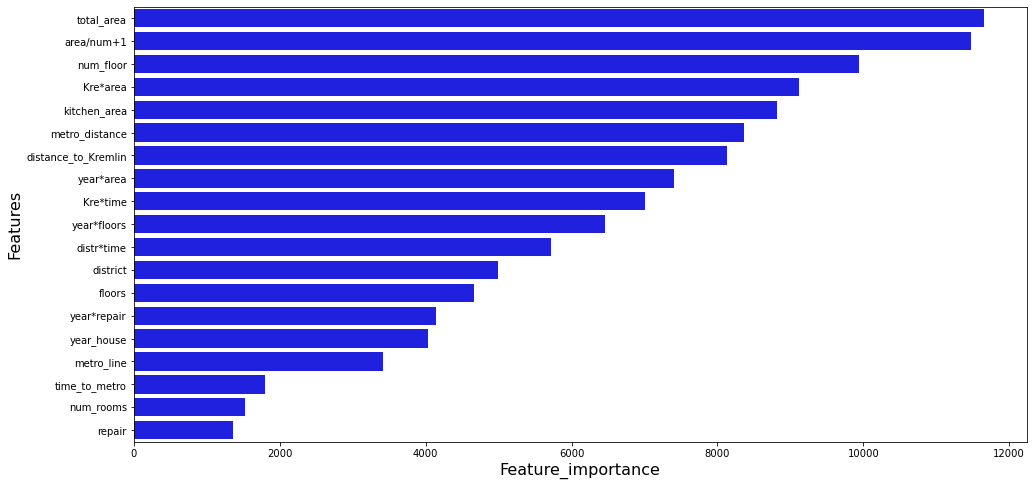

In [9]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    plt.figure(figsize=(16, 8))
    plt.xlabel('Feature_importance', fontsize=16)
    plt.ylabel('Features', fontsize=16)
    sns.barplot(list(f_dict.values()), list(f_dict.keys()), color='blue')

## Permutation importance

Метод основан на перестановке. Модель обучается на части данных, предсказывает результат на валидационной части данных с каким то качеством. Потом признак перемешивается на валидации, и модель делает предсказание еще раз. Разностью в качестве до перемешивания и после оценивается важность признака.

Смотрим важность на кроссвалидации.

In [10]:
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
perm_imp=[]
with open(os.devnull, "w") as f, contextlib.redirect_stdout(f):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        for tr_ind, val_ind in tqdm(skf.split(X, y)):
            
            lgbm=LGBMRegressor(bagging_fraction=0.5, random_state=42, **gd.best_params_)
            lgbm.fit(X.iloc[tr_ind,:], y.iloc[tr_ind])
            
            perm_imp.append(permutation_importance(lgbm, X.iloc[val_ind], y.iloc[val_ind], random_state=42, scoring='neg_mean_absolute_percentage_error', n_repeats=30))
            


5it [24:01, 288.37s/it]


Создаем табличку

In [11]:
perm_df=pd.DataFrame(columns=['fold №1', 'fold №2', 'fold №3', 'fold №4', 'fold №5', 'mean'], index=X.columns)
for i in range(1,6):
    perm_df[f'fold №{i}']=perm_imp[i-1]['importances_mean']
perm_df['mean']=perm_df.mean(axis=1)

In [12]:
perm_df

,fold №1,fold №2,fold №3,fold №4,fold №5,mean
time_to_metro,0.028767,0.029481,0.034583,0.034018,0.035555,0.032481
num_rooms,0.041848,0.037693,0.042300,0.041595,0.034753,0.039638
total_area,0.770653,0.798409,0.722495,0.783942,0.756283,0.766356
year_house,0.021191,0.019099,0.022371,0.020431,0.019265,0.020472
kitchen_area,0.022829,0.021613,0.022804,0.021086,0.023812,0.022429
repair,0.007236,0.005833,0.007180,0.006757,0.006605,0.006722
floors,0.050193,0.047444,0.049444,0.039178,0.040831,0.045418
num_floor,0.010706,0.012243,0.010974,0.010962,0.010981,0.011173
distance_to_Kremlin,0.186769,0.158012,0.206781,0.203091,0.196222,0.190175
district,0.034894,0.040290,0.035004,0.038722,0.036647,0.037111


Визуализация

<AxesSubplot:xlabel='Feature importance', ylabel='Features'>

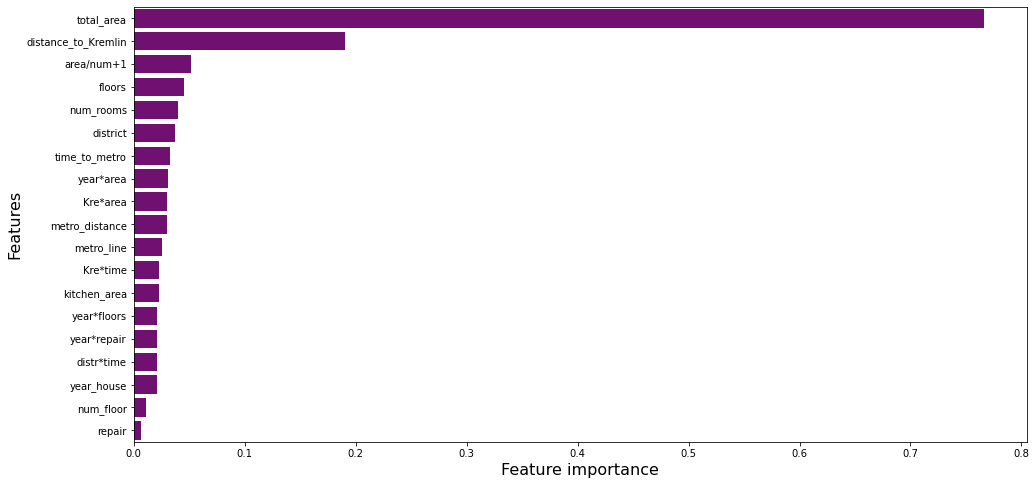

In [13]:
plt.figure(figsize=(16,8))
a=perm_df['mean'].sort_values()[::-1]
plt.xlabel('Feature importance', fontsize=16)
plt.ylabel('Features', fontsize=16)
sns.barplot(x=a.values, y=a.index, color='purple')

Результаты получились слегка отличающиеся от метода split.

## Жадное удаление признаков

Метод заключается в том, чтобы поочередно удалять признаки, обучать модель на новом датасете и сранивать качество с базом датасетом. Чем больше падение качества- тем выше значимость признака

Каждый раз будем смотреть качество на кросс валидации. Для каждого нового датасета надо будет "тюнить" модель

Качество базового датасета.

In [14]:
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
errors=[]

with open(os.devnull, "w") as f, contextlib.redirect_stdout(f):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        
        for tr_ind, val_ind in skf.split(X, y):
            lgbm=LGBMRegressor(bagging_fraction=0.5, **gd.best_params_, random_state=42)
            lgbm.fit(X.iloc[tr_ind,:], y.iloc[tr_ind])
            errors.append(mape(y.iloc[val_ind],lgbm.predict(X.iloc[val_ind,:])))
            
print(f'MAPE for f dataset: {np.mean(errors)}')

all_feat_error=np.mean(errors)

MAPE for f dataset: 0.15209498914130842


Поочередно удаляем признаки, тюним модель, получаем качество на кросс-валидации. Сохраняем в словарь.

In [15]:
errors_dict={}

feat_to_drop=[]
col_rfe=perm_df['mean'].sort_values().index
t=0.00001
c=list(f_dict.keys())[::-1]

for i in c:
    
    X_time=X.drop(feat_to_drop+[i], axis=1)

        
        
    errors_t=[]
    with open(os.devnull, "w") as f, contextlib.redirect_stdout(f):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            
            for tr_ind, val_ind in skf.split(X_time, y):
                lgbm=LGBMRegressor(bagging_fraction=0.5, **gd.best_params_, random_state=42)
                lgbm.fit(X_time.iloc[tr_ind,:], y.iloc[tr_ind])
                errors_t.append(mape(y.iloc[val_ind],lgbm.predict(X_time.iloc[val_ind,:])))
                
    errors_dict[i]=np.mean(errors_t)
    
    print(f'Error with drop {i}: {errors_dict[i]}')
    print(f'Error with all features: {all_feat_error}')
    diff_err=errors_dict[i]-all_feat_error
    
    print(f'Difference between errors for {i}: {diff_err}')
    
    if diff_err< t:
        feat_to_drop.append(i)
        print(f'Delete {i}')
    else:
        print(f'Remain {i}')
    print()

Error with drop repair: 0.15246181030764633
Error with all features: 0.15209498914130842
Difference between errors for repair: 0.00036682116633790507
Remain repair

Error with drop num_rooms: 0.15355616345645856
Error with all features: 0.15209498914130842
Difference between errors for num_rooms: 0.0014611743151501377
Remain num_rooms

Error with drop time_to_metro: 0.15432688875483427
Error with all features: 0.15209498914130842
Difference between errors for time_to_metro: 0.0022318996135258506
Remain time_to_metro

Error with drop metro_line: 0.15335858666080207
Error with all features: 0.15209498914130842
Difference between errors for metro_line: 0.0012635975194936477
Remain metro_line

Error with drop year_house: 0.15385505526398158
Error with all features: 0.15209498914130842
Difference between errors for year_house: 0.001760066122673154
Remain year_house

Error with drop year*repair: 0.15330379699949398
Error with all features: 0.15209498914130842
Difference between errors for ye

Признаки для удаления

In [16]:
print(feat_to_drop)

['year*floors', 'year*area']


## Split в динамике

Здесь мы посмотрим важность split в зависимости от максимальной глубины дерева

In [17]:
max_depth=[1,2,3,4,5]
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
dm_imp=[]
for num in max_depth:
    
    importance=[]
    
    with open(os.devnull, "w") as f, contextlib.redirect_stdout(f):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            
            for tr_ind, val_ind in skf.split(X, y):
                lgbm=LGBMRegressor(bagging_fraction=0.5, random_state=42, 
                                   **gd.best_params_, max_depth=num)
                
                lgbm.fit(X.iloc[tr_ind,:], y.iloc[tr_ind])
                
                importance.append(lgbm.booster_.feature_importance())


    feat_imp=np.mean(np.array(importance), axis=0)
    
    dm_imp.append(feat_imp)


Создадим таблицу

In [18]:
dm_imp_df=pd.DataFrame(columns=[f'depth {i}' for i in range(1, 6)], index=X.columns)

for i in range(1,6):
    dm_imp_df[f'depth {i}']= dm_imp[i-1]
dm_imp_df['mean']=dm_imp_df.mean(axis=1)


In [19]:
dm_imp_df

,depth 1,depth 2,depth 3,depth 4,depth 5,mean
time_to_metro,370.8,566.6,610.2,846.0,1201.6,719.04
num_rooms,76.6,230.4,389.4,685.6,1060.6,488.52
total_area,575.4,2276.8,3911.8,6090.2,8848.2,4340.48
year_house,287.8,336.4,696.0,1344.6,2323.8,997.72
kitchen_area,175.2,640.8,1720.4,3262.4,5461.0,2251.96
repair,23.2,62.2,212.2,452.2,783.8,306.72
floors,82.8,594.6,1107.8,1917.2,3135.2,1367.52
num_floor,42.0,251.4,1068.8,2622.0,5302.6,1857.36
distance_to_Kremlin,149.4,886.2,2092.4,3849.6,6091.2,2613.76
district,847.4,546.2,1095.8,2093.2,3299.4,1576.40


Визуализация

<AxesSubplot:xlabel='Feature importance', ylabel='Features'>

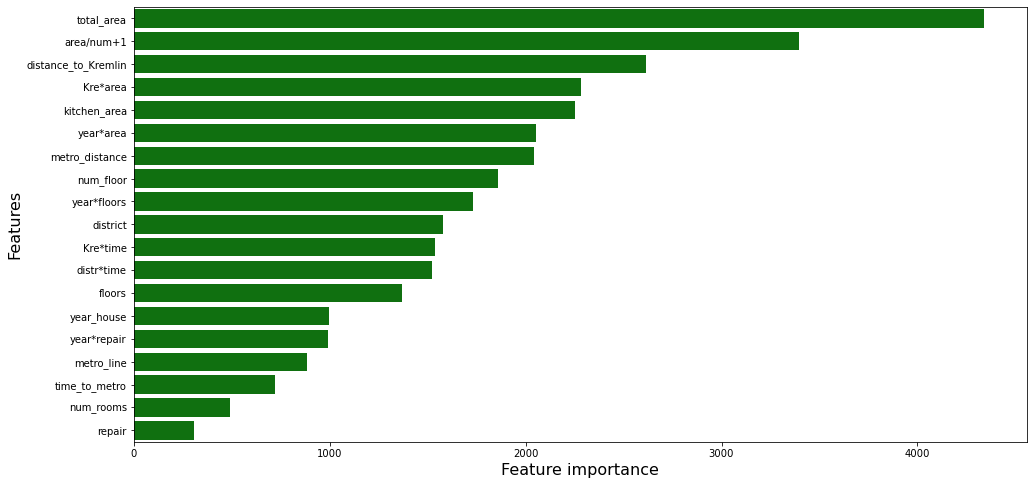

In [20]:
plt.figure(figsize=(16,8))
b=dm_imp_df['mean'].sort_values()[::-1]
plt.xlabel('Feature importance', fontsize=16)
plt.ylabel('Features', fontsize=16)
sns.barplot(x=b.values, y=b.index, color='green')

Разницы особо нет

## Модифицированный backward elimination features

Суть обычного backward elimination features заключается в том, что мы на каждой итерации алгоритма удаляем признак с самым большим p-значением и делаем это до тех пор, пока качество модели не достигнет пика. В нашем случае вместо максимального p-значения мы будем использовать минимальный прирост качества

In [7]:
fl=True
k=0
col_drop=[]

feat_imp=[]
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

while len(col_drop)<X.shape[1]:
    col_errors=[]
    for col in set(X.columns.to_list())-set(col_drop):
        
        X_time=X.drop([col]+col_drop, axis=1)
        
        with open(os.devnull, "w") as f, contextlib.redirect_stdout(f):
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")

                errors=[]

                for tr_ind, val_ind in skf.split(X_time, y):
                    lgbm=LGBMRegressor(bagging_fraction=0.5, random_state=42, 
                                       **{'lambda_l1': 15, 'learning_rate': 0.05, 'n_estimators': 4000})

                    lgbm.fit(X_time.iloc[tr_ind,:], y.iloc[tr_ind])

                    errors.append(mape(y.iloc[val_ind],lgbm.predict(X_time.iloc[val_ind,:])))
    
        
        col_errors.append([col,np.mean(errors)])

    
    min_col=min(col_errors, key=lambda x: x[1])
    
    col_drop.append(min_col[0])
    print(f'Feature "{min_col[0]}" delete with mape {min_col[1]}')
    feat_imp.append(col_errors)
    print()
    

Feature "year*area" delete with mape 0.15143800373114794

Feature "year*floors" delete with mape 0.15117689533251005

Feature "Kre*area" delete with mape 0.1513857780371489

Feature "distr*time" delete with mape 0.15159790356504022

Feature "repair" delete with mape 0.15189638617273435

Feature "area/num+1" delete with mape 0.15170917996633165

Feature "kitchen_area" delete with mape 0.15197662096459638

Feature "Kre*time" delete with mape 0.15254914710094822

Feature "metro_line" delete with mape 0.15336399426397934

Feature "metro_distance" delete with mape 0.1554956182012257

Feature "num_floor" delete with mape 0.15729029214503348

Feature "year_house" delete with mape 0.15984296127740413

Feature "time_to_metro" delete with mape 0.1683423710493157

Feature "year*repair" delete with mape 0.17937948697524028

Feature "num_rooms" delete with mape 0.19133737857867683

Feature "floors" delete with mape 0.21231014948919125

Feature "distance_to_Kremlin" delete with mape 0.24849224147440

In [22]:
col_errors

[['num_rooms', 1.3602795432000674]]

Список признаков для удаления

In [23]:
set(X.columns.to_list())-set(col_drop)

{'num_rooms'}

# Удаляем признаки

Самые частые кандидаты на удаление

In [24]:
bad_feats=['repair', 'year*repair']

Попробуем разные комбинации для удаления.

In [25]:
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)          
for i in [[],['repair','year*repair'],['repair'], ['year*repair']]:
    
    errors=[]
    
    X_t=X.drop(i, axis=1)

    with open(os.devnull, "w") as f, contextlib.redirect_stdout(f):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
    
            for tr_ind, val_ind in skf.split(X_t, y):

                    lgbm=LGBMRegressor(bagging_fraction=0.5, random_state=42, 
                                           **{'lambda_l1': 15, 'learning_rate': 0.05, 'n_estimators': 4000})

                    lgbm.fit(X_t.iloc[tr_ind,:], y.iloc[tr_ind])

                    errors.append(mape(y.iloc[val_ind],lgbm.predict(X_t.iloc[val_ind])))
                          
    print(f'Mape with delete this features: {i} equals {np.mean(errors)}')
    

Mape with delete this features: [] equals 0.15209498914130842
Mape with delete this features: ['repair', 'year*repair'] equals 0.16138905593620803
Mape with delete this features: ['repair'] equals 0.15246181030764633
Mape with delete this features: ['year*repair'] equals 0.15330379699949398


Удалим только repair. Будем считать, что улучшение/ ухудшение качества для mte кодировки такое же, как и для le.

In [9]:
df_le=df_le.drop('repair', axis=1)
df_mte=df_mte.drop('repair', axis=1)

# Сохраняем данные

In [10]:
df_le.to_csv(r"C:\Users\Stepan\Desktop\ВУЗ\Клиент-серверные\папка датафреймов\df_after_delete_le.csv")
df_mte.to_csv(r"C:\Users\Stepan\Desktop\ВУЗ\Клиент-серверные\папка датафреймов\df_after_delete_mte.csv")